# Iris flower dataset

We will be optimizing a Multilayer Perceptron(MLP) firstly its architecture and later by the best hyperparameter tuning, using genetic search algorithm.

In [1]:
from sklearn import datasets

data = datasets.load_iris()
X = data['data']
y = data['target']

print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: (150, 4)
y shape: (150,)


## Architecture search

In [2]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from joblib import parallel_backend

class MLPLayersTest:
    NUM_FOLDS = 5

    def __init__(self, randomSeed):

        self.randomSeed = randomSeed
        self.initDataset()
        self.kfold = KFold(n_splits=self.NUM_FOLDS, random_state=self.randomSeed, shuffle=True)

    def initDataset(self):
        self.data = datasets.load_iris()

        self.X = self.data['data']
        self.y = self.data['target']


    # params contains: [layer_1_size, layer_2_size, layer_3_size, layer_4_size]
    def convertParams(self, params):

        # transform the layer sizes from float (possibly negative) values into hiddenLayerSizes tuple:
        if round(params[1]) <= 0:
            hiddenLayerSizes = round(params[0]),
        elif round(params[2]) <= 0:
            hiddenLayerSizes = (round(params[0]), round(params[1]))
        elif round(params[3]) <= 0:
            hiddenLayerSizes = (round(params[0]), round(params[1]), round(params[2]))
        else:
            hiddenLayerSizes = (round(params[0]), round(params[1]), round(params[2]), round(params[3]))

        return hiddenLayerSizes

    def getAccuracy(self, params):
        hiddenLayerSizes = self.convertParams(params)

        self.classifier = MLPClassifier(random_state=self.randomSeed,
                                        hidden_layer_sizes=hiddenLayerSizes)

        cv_results = cross_val_score(self.classifier,
                                                     self.X,
                                                     self.y,
                                                     cv=self.kfold,
                                                     scoring='accuracy')

        return cv_results.mean()

    def formatParams(self, params):
        return "'hidden_layer_sizes'={}".format(self.convertParams(params))

In [3]:
from deap import base, creator, algorithms, tools

import random, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

toolbox = base.Toolbox()

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
test = MLPLayersTest(RANDOM_SEED)

# Initialize constants
BOUNDS_LOW = [5, -5, -10, -20]
BOUNDS_HIGH = [15, 10, 10, 10]
POPULATION_SIZE = 20
P_CROSSOVER = 0.9
P_MUTATION = 0.3
MAX_GENERATIONS = 10
HALL_OF_FAME_SIZE = 3
CROWDING_FACTOR = 10.0
NUM_OF_PARAMS = len(BOUNDS_HIGH)

In [4]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [5]:
# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)

# define the layer_size_attributes individually:
for i in range(NUM_OF_PARAMS):
    # "layer_size_attribute_0", "layer_size_attribute_1", ...
    toolbox.register("layer_size_attribute_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])

# create a tuple containing an layer_size_attribute generator for each hidden layer:
layer_size_attributes = ()
for i in range(NUM_OF_PARAMS):
    layer_size_attributes = layer_size_attributes + \
                            (toolbox.__getattribute__("layer_size_attribute_" + str(i)),)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 layer_size_attributes,
                 n=1)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator",
                 tools.initRepeat,
                 list,
                 toolbox.individualCreator)

# fitness calculation
def classificationAccuracy(individual):
    return test.getAccuracy(individual),

toolbox.register("evaluate", classificationAccuracy)

# genetic operators:mutFlipBit

# genetic operators:
toolbox.register("select", 
                 tools.selTournament, 
                 tournsize=2)

toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0/NUM_OF_PARAMS)


# Genetic Algorithm flow:
def GA_layers():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = eaSimpleWithElitism(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True)

    # print best solution found:
    print("- Best solution is: ",
          test.formatParams(hof.items[0]),
          ", accuracy = ",
          hof.items[0].fitness.values[0])
    
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
    
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red', label='max')
    plt.plot(meanFitnessValues, color='green', label='avg')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Max/Avg Fitness over Generations")
    plt.legend()
    plt.show()

gen	nevals	max     	avg     
0  	20    	0.973333	0.679667
1  	17    	0.973333	0.747333
2  	14    	0.973333	0.790333
3  	16    	0.973333	0.796667
4  	12    	0.98    	0.844333
5  	14    	0.98    	0.859667
6  	16    	0.98    	0.936   
7  	14    	0.98    	0.952667
8  	14    	0.98    	0.98    
9  	16    	0.98    	0.934667
10 	15    	0.98    	0.931667
- Best solution is:  'hidden_layer_sizes'=(15, 5, 8) , accuracy =  0.9800000000000001


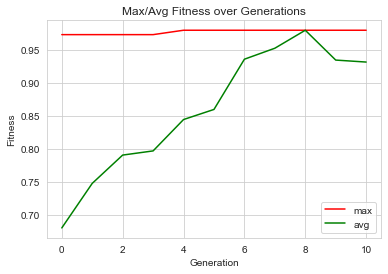

In [6]:
GA_layers()

## Hyperparameter tuning

We will integrate hyperparameter tuning with the above architecture search to further improve the fitness.

Parameters to tune:

|Name|Type|Description|Default value|
|-|-|-|-|
|activation|{'tanh', 'relu', 'logistic'}|Activation function for the hidden layers|'relu'|
|solver|{'sgd', 'adam', 'lbfgs'}|The solver for weight optimization|'adam'|
|alpha|float|Regularization term parameter|0.0001|
|learning_rate|{'constant', 'invscaling', 'adaptive'}|Learning rate schedule for weight updates|'constant'|

In [7]:
import math
from math import floor

BOUNDS_LOW =  [ 5,  -5, -10, -20, 0,     0,     0.0001, 0    ]
BOUNDS_HIGH = [15,  10,  10,  10, 2.999, 2.999, 2.0,    2.999]
NUM_OF_PARAMS = len(BOUNDS_HIGH)

# Genetic Algorithm constants:
POPULATION_SIZE = 30
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 10
HALL_OF_FAME_SIZE = 3
CROWDING_FACTOR = 10.0  # crowding factor for crossover and mutation

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

class MLPTest:
    NUM_FOLDS = 5

    def __init__(self, randomSeed):

        self.randomSeed = randomSeed
        self.initDataset()
        self.kfold = KFold(n_splits=self.NUM_FOLDS, random_state=self.randomSeed, shuffle=True)

    def initDataset(self):
        self.data = datasets.load_iris()

        self.X = self.data['data']
        self.y = self.data['target']


    # params contains: [layer_1_size, layer_2_size, layer_3_size, layer_4_size]
    def convertParams(self, params):

        # transform the layer sizes from float (possibly negative) values into hiddenLayerSizes tuple:
        if round(params[1]) <= 0:
            hiddenLayerSizes = round(params[0]),
        elif round(params[2]) <= 0:
            hiddenLayerSizes = (round(params[0]), round(params[1]))
        elif round(params[3]) <= 0:
            hiddenLayerSizes = (round(params[0]), round(params[1]), round(params[2]))
        else:
            hiddenLayerSizes = (round(params[0]), round(params[1]), round(params[2]), round(params[3]))

        activation = ['tanh', 'relu', 'logistic'][floor(params[4])]
        solver = ['sgd', 'adam', 'lbfgs'][floor(params[5])]
        alpha = params[6]
        learning_rate = ['constant', 'invscaling', 'adaptive'][floor(params[7])]
        
        return hiddenLayerSizes, activation, solver, alpha, learning_rate

    def getAccuracy(self, params):
        hiddenLayerSizes, activation, solver, alpha, learning_rate = self.convertParams(params)

        self.classifier = MLPClassifier(random_state=self.randomSeed,
                                        hidden_layer_sizes=hiddenLayerSizes,
                                        activation=activation,
                                        solver=solver,
                                        alpha=alpha,
                                        learning_rate=learning_rate
                                        )

        cv_results = cross_val_score(self.classifier,
                                                     self.X,
                                                     self.y,
                                                     cv=self.kfold,
                                                     scoring='accuracy')

        return cv_results.mean()

    def formatParams(self, params):
        hiddenLayerSizes, activation, solver, alpha, learning_rate = self.convertParams(params)
        return "'hidden_layer_sizes'={}\n " \
               "'activation'='{}'\n " \
               "'solver'='{}'\n " \
               "'alpha'={}\n " \
               "'learning_rate'='{}'"\
            .format(hiddenLayerSizes, activation, solver, alpha, learning_rate)

In [8]:
test = MLPTest(RANDOM_SEED)

toolbox = base.Toolbox()

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)

# define the layer size attributes individually:
for i in range(NUM_OF_PARAMS):
    # "attribute_0", "attribute_1", ...
    toolbox.register("attribute_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])

# create a tuple containing an attribute generator for each param searched:
attributes = ()
for i in range(NUM_OF_PARAMS):
    attributes = attributes + (toolbox.__getattribute__("attribute_" + str(i)),)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 attributes,
                 n=1)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator",
                 tools.initRepeat,
                 list,
                 toolbox.individualCreator)


# fitness calculation
def classificationAccuracy(individual):
    return test.getAccuracy(individual),


toolbox.register("evaluate", classificationAccuracy)

# genetic operators:mutFlipBit

# genetic operators:
toolbox.register("select",
                 tools.selTournament,
                 tournsize=2)

toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0/NUM_OF_PARAMS)

# Genetic Algorithm flow:
def GA():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = eaSimpleWithElitism(population,
                                              toolbox,
                                              cxpb=P_CROSSOVER,
                                              mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS,
                                              stats=stats,
                                              halloffame=hof,
                                              verbose=True)

    # print best solution found:
    print("- Best solution is: \n",
          test.formatParams(hof.items[0]),
          "\n => accuracy = ",
          hof.items[0].fitness.values[0])
    
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
    
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red', label='max')
    plt.plot(meanFitnessValues, color='green', label='avg')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Max/Avg Fitness over Generations")
    plt.legend()
    plt.show()

gen	nevals	max 	avg 
0  	30    	0.98	0.72
1  	26    	0.98	0.861111
2  	25    	0.98	0.933333
3  	20    	0.98	0.937333
4  	25    	0.98	0.939778
5  	24    	0.98	0.966444
6  	25    	0.98	0.977556
7  	24    	0.98	0.979556
8  	22    	0.98	0.979556
9  	26    	0.98	0.98    
10 	22    	0.98	0.969333
- Best solution is: 
 'hidden_layer_sizes'=(11,)
 'activation'='logistic'
 'solver'='lbfgs'
 'alpha'=1.7843699174529204
 'learning_rate'='constant' 
 => accuracy =  0.9800000000000001


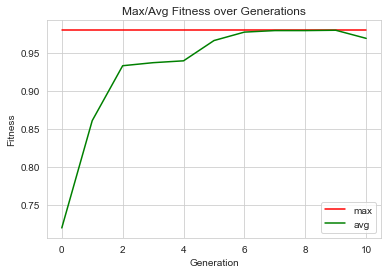

In [9]:
GA()